In [1]:
import os
import sys
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import models

In [2]:
dataset_path = "./Test_Images"
batch_size = 16
epochs = 50

In [3]:
train_dir = "./Test_Images/train"
val_dir = "./Test_Images/val"
test_dir = "./Test_Images/test"

# Create directories for training, validation, and test data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get paths to all image files in the dataset
image_paths = []
class_labels = os.listdir(dataset_path)
for label in class_labels:
    class_path = os.path.join(dataset_path, label)
    if os.path.isdir(class_path):
        image_paths.extend([os.path.join(class_path, fname) for fname in os.listdir(class_path)])

train_paths, temp_paths = train_test_split(image_paths, test_size=0.2, random_state=42) 
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

def move_images(image_paths, dest_dir):
    """
    Move images to their respective class directories.
    """
    for img_path in image_paths:
        if os.path.isfile(img_path):
            label = img_path.split('/')[-2]
            class_dest_dir = os.path.join(dest_dir, label)
            os.makedirs(class_dest_dir, exist_ok=True)
            shutil.copy(img_path, class_dest_dir)

# Move images to their respective directories
move_images(train_paths, train_dir)
move_images(val_paths, val_dir)
move_images(test_paths, test_dir)


In [4]:
train_dir = "./Test_Images/train"
val_dir = "./Test_Images/val"
test_dir = "./Test_Images/test"

# Create directories for training, validation, and test data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get paths to all image files in the dataset
image_paths = []
class_labels = os.listdir(dataset_path)
for label in class_labels:
    class_path = os.path.join(dataset_path, label)
    if os.path.isdir(class_path):
        image_paths.extend([os.path.join(class_path, fname) for fname in os.listdir(class_path)])

train_paths, temp_paths = train_test_split(image_paths, test_size=0.2, random_state=42) 
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

def move_images(image_paths, dest_dir):
    """
    Move images to their respective class directories.
    """
    for img_path in image_paths:
        if os.path.isfile(img_path):
            label = img_path.split('/')[-2]
            class_dest_dir = os.path.join(dest_dir, label)
            os.makedirs(class_dest_dir, exist_ok=True)
            shutil.copy(img_path, class_dest_dir)

# Move images to their respective directories
move_images(train_paths, train_dir)
move_images(val_paths, val_dir)
move_images(test_paths, test_dir)


In [5]:
print(len(train_paths))
print(len(val_paths))
print(len(test_paths))

2477
310
310


In [6]:
class SuppressTensorFlowOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self._original_stdout

with SuppressTensorFlowOutput():
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical'
    )

with SuppressTensorFlowOutput():
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical'
    )

with SuppressTensorFlowOutput():
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical'
    )


In [7]:
# Initialize the base model with Xception
base_model = Xception(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 76s 439ms/step - accuracy: 0.9770 - loss: 0.0874 - val_accuracy: 0.7500 - val_loss: 1.5500
Epoch 2/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:03 373ms/step - accuracy: 1.0000 - loss: 0.0425

2024-11-13 14:37:24.684938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0425 - val_accuracy: 0.5714 - val_loss: 2.1231
Epoch 3/50


2024-11-13 14:37:25.043534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 66s 382ms/step - accuracy: 0.9772 - loss: 0.0841 - val_accuracy: 0.7422 - val_loss: 1.6476
Epoch 4/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - accuracy: 0.9375 - loss: 0.1275

2024-11-13 14:38:31.316914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:38:31.512127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1275 - val_accuracy: 0.8571 - val_loss: 0.4004
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 47s 272ms/step - accuracy: 0.9598 - loss: 0.1707 - val_accuracy: 0.6816 - val_loss: 1.5331
Epoch 6/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 1.0000 - loss: 0.1145

2024-11-13 14:39:18.800794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.1145 - val_accuracy: 0.7143 - val_loss: 2.8983
Epoch 7/50


2024-11-13 14:39:19.117692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 75s 437ms/step - accuracy: 0.9001 - loss: 0.4453 - val_accuracy: 0.7207 - val_loss: 1.2446
Epoch 8/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - accuracy: 1.0000 - loss: 0.0607

2024-11-13 14:40:34.926541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0607 - val_accuracy: 0.7857 - val_loss: 1.2619
Epoch 9/50


2024-11-13 14:40:35.353097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 71s 413ms/step - accuracy: 0.9639 - loss: 0.1301 - val_accuracy: 0.7207 - val_loss: 1.3580
Epoch 10/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:06 389ms/step - accuracy: 1.0000 - loss: 0.1011

2024-11-13 14:41:47.077551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.1011 - val_accuracy: 0.9286 - val_loss: 0.1071
Epoch 11/50


2024-11-13 14:41:47.399825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 75s 434ms/step - accuracy: 0.9781 - loss: 0.0959 - val_accuracy: 0.7363 - val_loss: 1.5144
Epoch 12/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:09 407ms/step - accuracy: 0.9375 - loss: 0.1411

2024-11-13 14:43:02.665681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.1411 - val_accuracy: 0.5000 - val_loss: 3.2851
Epoch 13/50


2024-11-13 14:43:03.043063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 79s 460ms/step - accuracy: 0.9807 - loss: 0.0803 - val_accuracy: 0.7188 - val_loss: 1.7039
Epoch 14/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:00 356ms/step - accuracy: 0.8750 - loss: 0.3112

2024-11-13 14:44:22.830658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.3112 - val_accuracy: 0.7143 - val_loss: 1.0418
Epoch 15/50


2024-11-13 14:44:23.184635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 78s 451ms/step - accuracy: 0.9789 - loss: 0.0732 - val_accuracy: 0.7324 - val_loss: 1.5785
Epoch 16/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:04 376ms/step - accuracy: 1.0000 - loss: 0.0394

2024-11-13 14:45:41.327786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0394 - val_accuracy: 0.6429 - val_loss: 2.8385
Epoch 17/50


2024-11-13 14:45:41.671549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 79s 459ms/step - accuracy: 0.9759 - loss: 0.0762 - val_accuracy: 0.7207 - val_loss: 1.7377
Epoch 18/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:05 385ms/step - accuracy: 1.0000 - loss: 0.0866

2024-11-13 14:47:01.226422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0866 - val_accuracy: 0.9286 - val_loss: 0.2191
Epoch 19/50


2024-11-13 14:47:01.590832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 73s 424ms/step - accuracy: 0.9798 - loss: 0.0648 - val_accuracy: 0.7305 - val_loss: 1.6622
Epoch 20/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:06 390ms/step - accuracy: 1.0000 - loss: 0.0101

2024-11-13 14:48:15.207179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.7857 - val_loss: 0.6054
Epoch 21/50


2024-11-13 14:48:15.540416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 75s 434ms/step - accuracy: 0.9861 - loss: 0.0567 - val_accuracy: 0.7246 - val_loss: 1.7357
Epoch 22/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:06 391ms/step - accuracy: 0.9375 - loss: 0.0932

2024-11-13 14:49:30.789760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.0932 - val_accuracy: 0.6429 - val_loss: 1.4328
Epoch 23/50


2024-11-13 14:49:31.132382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 75s 434ms/step - accuracy: 0.9752 - loss: 0.0714 - val_accuracy: 0.7207 - val_loss: 1.6953
Epoch 24/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:04 377ms/step - accuracy: 1.0000 - loss: 0.0264

2024-11-13 14:50:46.442423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 0.7143 - val_loss: 3.6668
Epoch 25/50


2024-11-13 14:50:46.776908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 72s 418ms/step - accuracy: 0.9838 - loss: 0.0582 - val_accuracy: 0.7422 - val_loss: 1.6587
Epoch 26/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:01 360ms/step - accuracy: 1.0000 - loss: 0.0046

2024-11-13 14:51:59.302121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.7857 - val_loss: 0.7871
Epoch 27/50


2024-11-13 14:51:59.641133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 75s 437ms/step - accuracy: 0.9794 - loss: 0.0649 - val_accuracy: 0.7305 - val_loss: 1.7487
Epoch 28/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 1:01 361ms/step - accuracy: 1.0000 - loss: 0.0114

2024-11-13 14:53:15.340468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 0.7857 - val_loss: 0.4903
Epoch 29/50


2024-11-13 14:53:15.674478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 64s 370ms/step - accuracy: 0.9789 - loss: 0.0649 - val_accuracy: 0.7227 - val_loss: 1.8046
Epoch 30/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 36s 214ms/step - accuracy: 1.0000 - loss: 0.0035

2024-11-13 14:54:19.828827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:54:20.025402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.7143 - val_loss: 1.5074
Epoch 31/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 45s 259ms/step - accuracy: 0.9796 - loss: 0.0657 - val_accuracy: 0.7266 - val_loss: 1.8551
Epoch 32/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 1.0000 - loss: 0.0204

2024-11-13 14:55:05.037867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0204 - val_accuracy: 0.7857 - val_loss: 0.8625
Epoch 33/50


2024-11-13 14:55:05.243366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 256ms/step - accuracy: 0.9790 - loss: 0.0625 - val_accuracy: 0.7402 - val_loss: 1.7385
Epoch 34/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.8750 - loss: 0.2745

2024-11-13 14:55:49.784350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2745 - val_accuracy: 0.7143 - val_loss: 2.0354
Epoch 35/50


2024-11-13 14:55:49.985898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 255ms/step - accuracy: 0.9843 - loss: 0.0504 - val_accuracy: 0.7227 - val_loss: 1.8281
Epoch 36/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 36s 214ms/step - accuracy: 1.0000 - loss: 0.0613

2024-11-13 14:56:34.355252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:56:34.555217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0613 - val_accuracy: 0.8571 - val_loss: 0.6791
Epoch 37/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 254ms/step - accuracy: 0.9823 - loss: 0.0617 - val_accuracy: 0.7363 - val_loss: 1.8952
Epoch 38/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - accuracy: 1.0000 - loss: 0.0049

2024-11-13 14:57:18.720520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:57:18.916027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.8571 - val_loss: 0.5334
Epoch 39/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 254ms/step - accuracy: 0.9819 - loss: 0.0527 - val_accuracy: 0.7344 - val_loss: 1.9168
Epoch 40/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 37s 221ms/step - accuracy: 1.0000 - loss: 0.0193

2024-11-13 14:58:02.972754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:58:03.165252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.7857 - val_loss: 0.9059
Epoch 41/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 255ms/step - accuracy: 0.9774 - loss: 0.0598 - val_accuracy: 0.7246 - val_loss: 1.8887
Epoch 42/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 37s 217ms/step - accuracy: 1.0000 - loss: 0.0090

2024-11-13 14:58:47.515938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:58:47.709083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.7143 - val_loss: 2.2741
Epoch 43/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 255ms/step - accuracy: 0.9814 - loss: 0.0522 - val_accuracy: 0.7207 - val_loss: 1.9009
Epoch 44/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 1.0000 - loss: 0.0427

2024-11-13 14:59:32.053704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:59:32.249390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0427 - val_accuracy: 0.9286 - val_loss: 0.5832
Epoch 45/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - accuracy: 0.9813 - loss: 0.0532 - val_accuracy: 0.7285 - val_loss: 1.9483
Epoch 46/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 37s 222ms/step - accuracy: 1.0000 - loss: 0.0386

2024-11-13 15:00:16.996228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 15:00:17.191979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0386 - val_accuracy: 0.5714 - val_loss: 3.4975
Epoch 47/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 256ms/step - accuracy: 0.9809 - loss: 0.0512 - val_accuracy: 0.7266 - val_loss: 1.9707
Epoch 48/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 36s 214ms/step - accuracy: 1.0000 - loss: 0.0053

2024-11-13 15:01:01.627100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 15:01:01.826890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.7857 - val_loss: 1.2966
Epoch 49/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 256ms/step - accuracy: 0.9853 - loss: 0.0458 - val_accuracy: 0.7285 - val_loss: 2.0119
Epoch 50/50
  1/172 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - accuracy: 1.0000 - loss: 0.0020

2024-11-13 15:01:46.287864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 15:01:46.485316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8571 - val_loss: 0.8790


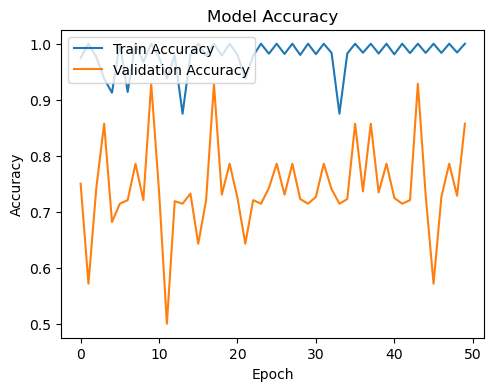

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)


52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.8383 - loss: 1.2063
